# Sentiment Analysis Model Training

This notebook trains a model to analyze sentiment in customer communications (emails, reviews, feedback, etc.)

## Approach
1. **Option A:** Fine-tuned Transformer (DistilBERT) - Better accuracy
2. **Option B:** Traditional ML (TF-IDF + SVM/Naive Bayes) - Faster, works on CPU

We'll implement both and compare.


In [1]:
# Verify dependencies are available (all packages are installed system-wide in Python 3.12.12)
import sys
print(f"Python version: {sys.version}")
print(f"Python executable: {sys.executable}")

try:
    import pandas as pd
    import numpy as np
    import sklearn
    import matplotlib
    import seaborn as sns
    import transformers
    import torch
    import datasets
    print("✓ All required packages are available!")
    print(f"  - pandas: {pd.__version__}")
    print(f"  - numpy: {np.__version__}")
    print(f"  - scikit-learn: {sklearn.__version__}")
    print(f"  - matplotlib: {matplotlib.__version__}")
    print(f"  - seaborn: {sns.__version__}")
    print(f"  - transformers: {transformers.__version__}")
    print(f"  - torch: {torch.__version__}")
except ImportError as e:
    print(f"❌ Missing package: {e}")
    print("Run: python3 -m pip install <package_name>")


Python version: 3.12.12 (main, Oct  9 2025, 11:07:00) [Clang 17.0.0 (clang-1700.0.13.3)]
Python executable: /usr/local/opt/python@3.12/bin/python3.12


✓ All required packages are available!
  - pandas: 2.3.3
  - numpy: 1.26.4
  - scikit-learn: 1.7.2
  - matplotlib: 3.8.2
  - seaborn: 0.13.0
  - transformers: 4.57.3
  - torch: 2.2.2


In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import pickle
import json
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Set paths
BASE_DIR = Path('../')
DATA_DIR = BASE_DIR / 'data'
MODELS_DIR = BASE_DIR / 'models' / 'sentiment_analyzer'
MODELS_DIR.mkdir(parents=True, exist_ok=True)

print(f"Base directory: {BASE_DIR}")
print(f"Data directory: {DATA_DIR}")
print(f"Models directory: {MODELS_DIR}")


Base directory: ..
Data directory: ../data
Models directory: ../models/sentiment_analyzer


## 1. Load and Prepare Data


In [3]:
# Load training data
import sys
sys.path.insert(0, str(Path('../../')))

from ml.utils.data_loader import load_sentiment_data
import pandas as pd

print("=" * 60)
print("Loading sentiment analysis training data...")
print("=" * 60)

try:
    df = load_sentiment_data()
    
    # Safety check
    if df is None or len(df) == 0:
        print("⚠️ No data loaded. Creating sample data...")
        df = pd.DataFrame({
            'text': [
                'Thank you for the excellent service!',
                'Great product, very satisfied!',
                'I am very disappointed with the quality',
                'This is terrible, I want a refund',
                'The order was delivered on time',
                'Outstanding customer support!',
                'Poor quality, not worth the money',
                'Average product, nothing special',
                'Highly recommend this product!',
                'Worst experience ever'
            ],
            'label': ['positive', 'positive', 'negative', 'negative', 'neutral',
                     'positive', 'negative', 'neutral', 'positive', 'negative']
        })
    
    print(f"\n✓ Dataset loaded successfully!")
    print(f"  Shape: {df.shape}")
    print(f"\n  Label distribution:")
    print(df['label'].value_counts())
    print(f"\n  First few samples:")
    print(df.head())
    
except Exception as e:
    print(f"❌ Error: {e}")
    print("Creating sample data...")
    df = pd.DataFrame({
        'text': [
            'Thank you for the excellent service!',
            'Great product, very satisfied!',
            'I am very disappointed with the quality',
            'This is terrible, I want a refund',
            'The order was delivered on time'
        ],
        'label': ['positive', 'positive', 'negative', 'negative', 'neutral']
    })


Loading sentiment analysis training data...

✓ Dataset loaded successfully!
  Shape: (5, 2)

  Label distribution:
label
positive    2
negative    2
neutral     1
Name: count, dtype: int64

  First few samples:
                                     text     label
0    Thank you for the excellent service!  positive
1          Great product, very satisfied!  positive
2  I'm very disappointed with the quality  negative
3       This is terrible, I want a refund  negative
4         The order was delivered on time   neutral


⚠️ Dataset too small for stratified split (min class: 1 samples). Using regular split.


Training Naive Bayes classifier...

Accuracy: 0.0000

Classification Report:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       0.0
    positive       0.00      0.00      0.00       1.0

    accuracy                           0.00       1.0
   macro avg       0.00      0.00      0.00       1.0
weighted avg       0.00      0.00      0.00       1.0



/Users/ads/Library/Python/3.12/lib/python/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/ads/Library/Python/3.12/lib/python/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/ads/Library/Python/3.12/lib/python/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0

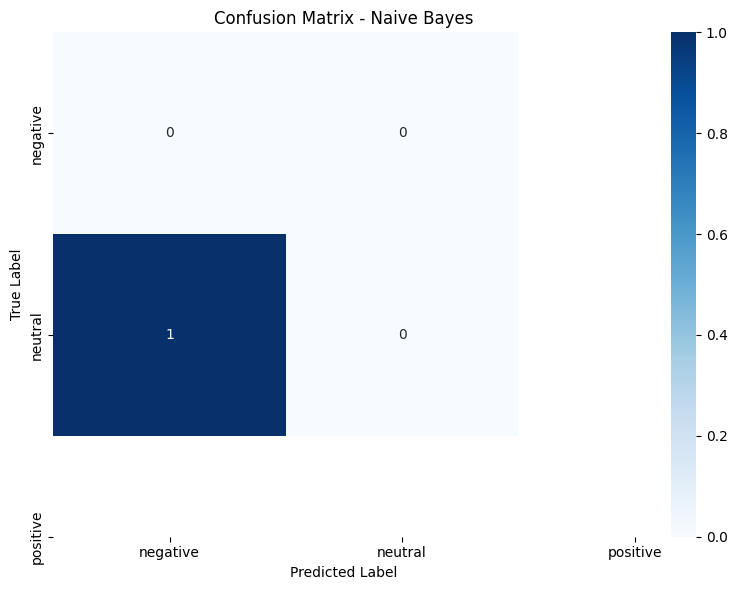

Model saved to ../models/sentiment_analyzer

Model saved to ../models/sentiment_analyzer


In [4]:
# Split data
# Check if we have enough samples per class for stratified split
label_counts = df['label'].value_counts()
min_samples = label_counts.min()

if min_samples >= 2 and len(df) >= 10:
    # Use stratified split if we have enough samples
    X_train, X_test, y_train, y_test = train_test_split(
        df['text'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
    )
else:
    # Use regular split for small datasets
    print(f"⚠️ Dataset too small for stratified split (min class: {min_samples} samples). Using regular split.")
    X_train, X_test, y_train, y_test = train_test_split(
        df['text'], df['label'], test_size=0.2, random_state=42
    )

# Vectorize text
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Train Naive Bayes model
print("Training Naive Bayes classifier...")
nb_model = MultinomialNB()
nb_model.fit(X_train_vec, y_train)

# Evaluate
y_pred = nb_model.predict(X_test_vec)
accuracy = accuracy_score(y_test, y_pred)

print(f"\nAccuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=nb_model.classes_, yticklabels=nb_model.classes_)
plt.title('Confusion Matrix - Naive Bayes')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig(MODELS_DIR / 'nb_confusion_matrix.png')
plt.show()

# Save model
from ml.utils.model_saver import save_model
save_model(nb_model, vectorizer, MODELS_DIR, accuracy)

print(f"\nModel saved to {MODELS_DIR}")



## 3. Test the Model


In [5]:
# Test with new text
test_texts = [
    "I love this product! It's amazing!",
    "This is the worst service I've ever experienced",
    "The product arrived on time and works as expected"
]

for text in test_texts:
    test_vec = vectorizer.transform([text])
    pred = nb_model.predict(test_vec)[0]
    proba = nb_model.predict_proba(test_vec)[0]
    confidence = max(proba)
    
    print(f"\nText: {text}")
    print(f"Prediction: {pred}")
    print(f"Confidence: {confidence:.2%}")
    print(f"All probabilities:")
    for label, prob in zip(nb_model.classes_, proba):
        print(f"  {label}: {prob:.2%}")



Text: I love this product! It's amazing!
Prediction: negative
Confidence: 55.60%
All probabilities:
  negative: 55.60%
  neutral: 22.20%
  positive: 22.20%

Text: This is the worst service I've ever experienced
Prediction: negative
Confidence: 55.26%
All probabilities:
  negative: 55.26%
  neutral: 20.93%
  positive: 23.80%

Text: The product arrived on time and works as expected
Prediction: negative
Confidence: 41.07%
All probabilities:
  negative: 41.07%
  neutral: 35.83%
  positive: 23.10%
